Train one XGBoost model to predict streamflow for all stations. Forcings are aggregated from hourly to daily to match streamflow resolution. RandomSearchCV to find good parameters.

Use NSE custom objective.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
import xgboost as xgb
import scipy as sp
from src import load_data, evaluate

np.random.seed(0)

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
time_stamp

'20190908-103648'

In [2]:
station_data_dict = load_data.load_train_test_gridded_aggregatedForcings(include_all_forcing_vars=False)

In [3]:
param_dist = {
    'max_depth': sp.stats.randint(2, 8),
    #'learning_rate': sp.stats.uniform(0.005, 0.1),
    'gamma': sp.stats.uniform(0, 5),
    'min_child_weight': sp.stats.randint(1, 30),
    'subsample': sp.stats.uniform(0.4, 0.1),
    'colsample_bytree': sp.stats.uniform(0.3, 0.7),
    'colsample_bylevel': sp.stats.uniform(0.3, 0.7),
    #'reg_alpha': sp.stats.expon(0, 20),
    #'reg_lambda': sp.stats.expon(0, 20),
}

In [4]:
class NSEObjective:
    """Custom NSE XGBoost objective.
    
    This is a bit of a hack: We use a unique dummy target value for each sample, allowing us to look up
    the mean that corresponds to the sample's station.
    When calculating the loss, we replace the dummy with the actual target, so the model learns the right thing.
    """
    def __init__(self, dummy_target, actual_target, means, stations):
        self.dummy_target = dummy_target.to_numpy()
        self.actual_target = actual_target.to_numpy()
        self.means = means.to_numpy()
        self.stations = stations.to_numpy()
        
    def nse_objective(self, y_true, y_pred):
        """ NSE objective for XGBoost, slightly modified to normalize with mean """
        indices = np.searchsorted(self.dummy_target, y_true)
        actual_target = self.actual_target[indices]
        means = self.means[indices]
        stations = self.stations[indices]
        grad, hess = np.empty(len(y_pred)), np.empty(len(y_pred))
        for station in np.unique(stations):
            station_mask = stations == station
            # normalize with mean instead of sum, because otherwise the gradients would be too small.
            normalization = np.mean(np.square(actual_target[station_mask] - means[station_mask]))
            grad[station_mask] = 2 * (y_pred[station_mask] - actual_target[station_mask]) / normalization
            hess[station_mask] = 2.0 / normalization
        return grad, hess
    
    def nse(self, y_pred, y_true, means):
        return np.sum(np.square(y_pred - y_true)) / np.sum(np.square(y_true - means))
    
    def nse_metric(self, y_pred, y_true):
        """ NSE metric for XGBoost """
        indices = np.searchsorted(self.dummy_target, y_true.get_label())
        actual_target = self.actual_target[indices]
        stations = self.stations[indices]
        means = self.means[indices]
        unique_stations = np.unique(stations)
        nse = 0.0
        # group by station to calculate NSE per station, then average
        for station in unique_stations:
            station_mask = stations == station
            nse += self.nse(y_pred[station_mask], actual_target[station_mask], means[station_mask])
        
        return 'nse', nse / len(unique_stations)
    
    def neg_nse_metric_sklearn(self, estimator, X, y_true):
        """ -NSE metric for sklearn """
        y_pred = estimator.predict(X)
        indices = np.searchsorted(self.dummy_target, y_true)
        actual_target = self.actual_target[indices]
        stations = self.stations[indices]
        means = self.means[indices]
        unique_stations = np.unique(stations)
        nse = 0.0
        # group by station to calculate NSE per station, then average
        for station in unique_stations:
            station_mask = stations == station
            nse += self.nse(y_pred[station_mask], actual_target[station_mask], means[station_mask])
        
        return -nse / len(unique_stations)

In [5]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)
train_end = '2012-12-31'
test_start = datetime.strptime(train_end, '%Y-%m-%d') + timedelta(days=1)
test_end = '2014-12-31'

validation_fraction = 0.1

data = pd.DataFrame()
data = pd.concat([station_data_dict[station].reset_index() for station in station_data_dict.keys()], ignore_index=True)

data = data.join(pd.get_dummies(data['station'], prefix='station'))
print(data.shape)

data['dummy_target'] = range(len(data))
means = data.groupby('station')['runoff'].mean()
data = data.join(means, on='station', rsuffix='_mean')
nse_loss = NSEObjective(data['dummy_target'], data['runoff'], data['runoff_mean'], data['station'])

train = data[(data['date'] >= train_start) & (data['date'] <= train_end)].copy()
num_validation_samples = int(validation_fraction * train.shape[0])
shuffle_indices = np.arange(train.shape[0])
np.random.shuffle(shuffle_indices)
train = train.iloc[shuffle_indices]
val, train = train.iloc[:num_validation_samples].copy(), train.iloc[num_validation_samples:].copy()

test = data[(data['date'] >= test_start) & (data['date'] <= test_end)].copy()
print('Shapes: train {}, val {}, test {}'.format(train.shape, val.shape, test.shape))

val = [(train.drop(['station', 'date', 'runoff', 'dummy_target', 'runoff_mean'], axis=1), train['dummy_target']), 
       (val.drop(['station', 'date', 'runoff', 'dummy_target', 'runoff_mean'], axis=1), val['dummy_target'])]

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.2, objective=nse_loss.nse_objective, n_jobs=1, random_state=123)
m = model_selection.RandomizedSearchCV(xgb_model, param_dist, n_iter=10000, cv=2, return_train_score=True, scoring=nse_loss.neg_nse_metric_sklearn, n_jobs=-1, random_state=123, verbose=5)
m.fit(train.drop(['station', 'date', 'runoff', 'dummy_target', 'runoff_mean'], axis=1), train['dummy_target'], eval_set=val, 
              eval_metric=nse_loss.nse_metric, early_stopping_rounds=50, verbose=False)

cv_results = pd.DataFrame(m.cv_results_).sort_values(by='mean_test_score', ascending=False)
print(cv_results.filter(regex='param_|mean_test_score|mean_train_score', axis=1).head())
print('Best params: {}'.format(m.best_params_))
print(cv_results.loc[m.best_index_, ['mean_train_score', 'mean_test_score']])

test = test[~pd.isna(test['runoff'])]

predict = test.copy()
predict['actual'] = predict['runoff']
predict['runoff'] = np.nan
predict['runoff'] = m.predict(predict.drop(['station', 'actual', 'date', 'runoff', 'dummy_target', 'runoff_mean'], axis=1))

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


(82918, 8773)
Shapes: train (44081, 8775), val (4897, 8775), test (33580, 8775)
Fitting 2 folds for each of 10000 candidates, totalling 20000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed: 37.0min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 48.0min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 60.4min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 74.5min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 89.3min
[Parallel(n_jobs=-1)]: Done 2866 tasks      | elapsed: 104.9min
[Parallel(n_jobs=-1)]: Done 3352 tasks      | elapsed: 122.0min
[Parallel(n_jobs=-1)]: Done 3874 tasks      | elapsed: 140.2min
[Parallel(n_jobs=-1)]: Done 4432 tasks      | elapsed: 159.8min
[Parallel(n_jobs=-1)]: Done 5026 tasks      | elapsed: 181.0min
[Parallel(n_jobs=-1)]: Done 5656 tasks   

     param_colsample_bylevel param_colsample_bytree param_gamma  \
2623                0.923707               0.454028    0.998064   
7647                0.898148               0.656943   0.0656198   
5440                0.499085               0.960157     3.61335   
4586                0.940704               0.683211    0.714582   
7509                0.854011               0.964815      1.9952   

     param_max_depth param_min_child_weight param_subsample  mean_test_score  \
2623               7                      1        0.483177        -0.712665   
7647               7                      1        0.453593        -0.721314   
5440               6                      1        0.482601        -0.723392   
4586               7                      1        0.494253        -0.723840   
7509               7                      1        0.454031        -0.725755   

      mean_train_score  
2623         -0.615207  
7647         -0.624102  
5440         -0.631348  
4586         -0.

02GA010 	NSE: 0.29038040321883485 	MSE: 338.32785307853663 (clipped to 0)
02GA018 	NSE: 0.2881924213583028 	MSE: 178.7727372813167 (clipped to 0)
02GA038 	NSE: 0.21014016428418647 	MSE: 129.96231855883642 (clipped to 0)
02GA047 	NSE: 0.16423359944937488 	MSE: 65.51574875305485 (clipped to 0)
02GB001 	NSE: -0.4004991514916241 	MSE: 10517.573843450786 (clipped to 0)
02GB007 	NSE: 0.3463866125716558 	MSE: 20.439807347826523 (clipped to 0)
02GC002 	NSE: 0.3862299392816172 	MSE: 78.87131536151658 (clipped to 0)
02GC007 	NSE: 0.44637925836573034 	MSE: 16.675801066612586 (clipped to 0)
02GC010 	NSE: 0.4215059350134698 	MSE: 34.39142576757034 (clipped to 0)
02GC018 	NSE: 0.4825491589811093 	MSE: 35.04529051165654 (clipped to 0)
02GC026 	NSE: 0.44072524787966605 	MSE: 89.94969825795421 (clipped to 0)
02GD004 	NSE: 0.36379416649980534 	MSE: 35.03144851578107 (clipped to 0)
02GE007 	NSE: 0.38346936709086077 	MSE: 22.30303169997049 (clipped to 0)
02GG002 	NSE: 0.46797212053747583 	MSE: 128.3159877

../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04166100 	NSE: 0.39181513872434615 	MSE: 4.46000671777603 (clipped to 0)
04166500 	NSE: 0.4453824993538398 	MSE: 19.169961439020543 (clipped to 0)
04174500 	NSE: 0.21905577715842328 	MSE: 73.85720369133465 (clipped to 0)
04176500 	NSE: 0.14877902221607753 	MSE: 581.4471023601445 (clipped to 0)
04177000 	NSE: 0.25780688267010043 	MSE: 20.00197819897138 (clipped to 0)
04193500 	NSE: -0.3618136129772358 	MSE: 96417.42416192855 (clipped to 0)


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04195820 	NSE: -0.119948948621873 	MSE: 1314.5897316812961 (clipped to 0)
04196800 	NSE: 0.10994576595324046 	MSE: 266.34738286687974 (clipped to 0)
04197100 	NSE: 0.2435214357314487 	MSE: 77.58777742770152 (clipped to 0)
04198000 	NSE: -0.02401110061820022 	MSE: 7564.942834057497 (clipped to 0)
04199000 	NSE: 0.14910030662085094 	MSE: 870.1328342362734 (clipped to 0)
04199500 	NSE: 0.09414797753364101 	MSE: 366.55131966479166 (clipped to 0)


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04200500 	NSE: 0.08021728517261195 	MSE: 920.4311210860345 (clipped to 0)
04207200 	NSE: 0.4046760000296694 	MSE: 13.934326958049352 (clipped to 0)
04208504 	NSE: 0.17610051587941888 	MSE: 804.5614560500329 (clipped to 0)
04209000 	NSE: 0.29385301720226265 	MSE: 220.7811023512435 (clipped to 0)


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04212100 	NSE: 0.2031261694332257 	MSE: 1170.0697970103267 (clipped to 0)
04213000 	NSE: 0.21565350666817207 	MSE: 140.76606621804783 (clipped to 0)
04213500 	NSE: 0.2030731033806874 	MSE: 816.3853358685402 (clipped to 0)
04214500 	NSE: 0.35209891082284606 	MSE: 78.09610998918626 (clipped to 0)
04215000 	NSE: 0.27583105348229053 	MSE: 69.55846426978557 (clipped to 0)
04215500 	NSE: 0.29424834789335974 	MSE: 127.44809966964998 (clipped to 0)
Median NSE (clipped to 0) 0.2940506825478112 / Min -0.4004991514916241 / Max 0.5074934407571137
Median MSE (clipped to 0) 100.31467262124539 / Min 4.46000671777603 / Max 96417.42416192855


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

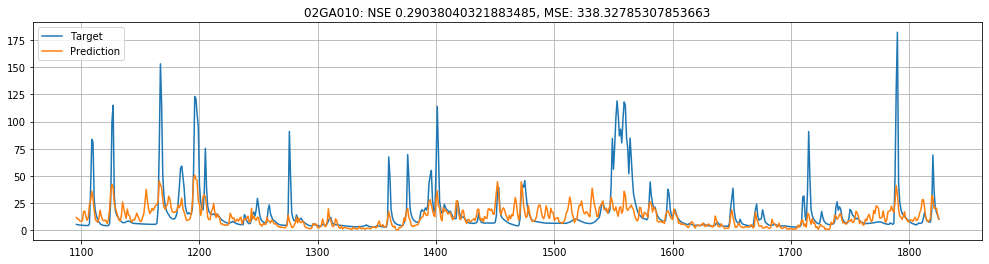

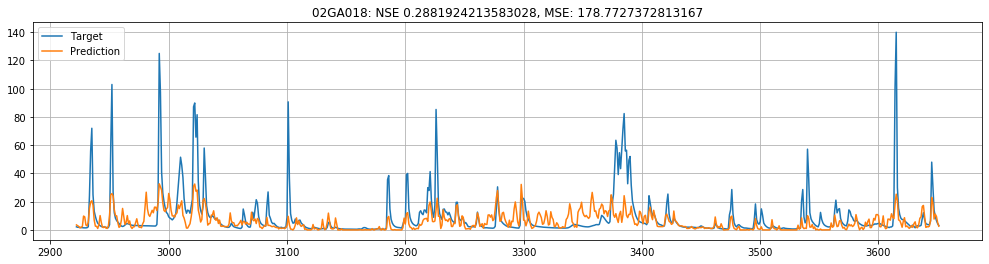

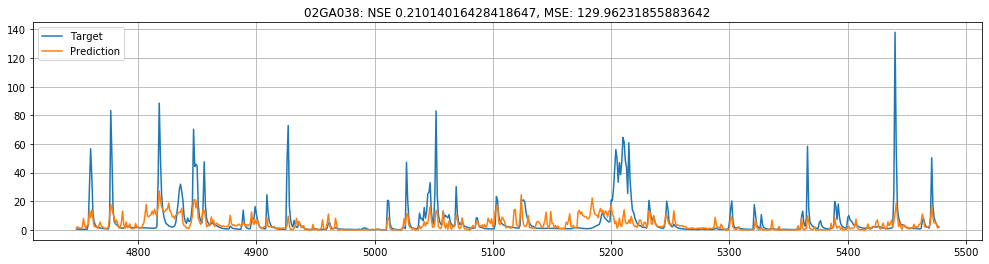

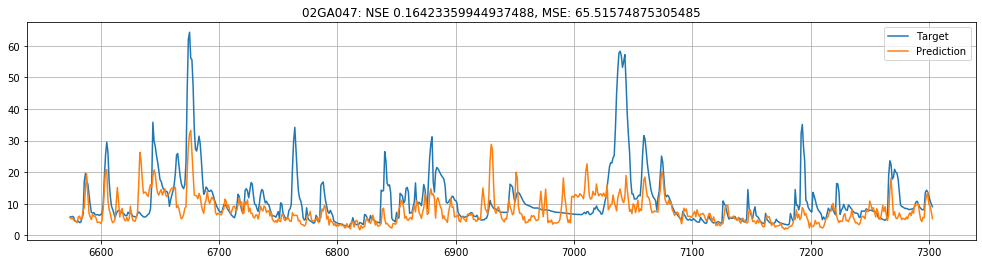

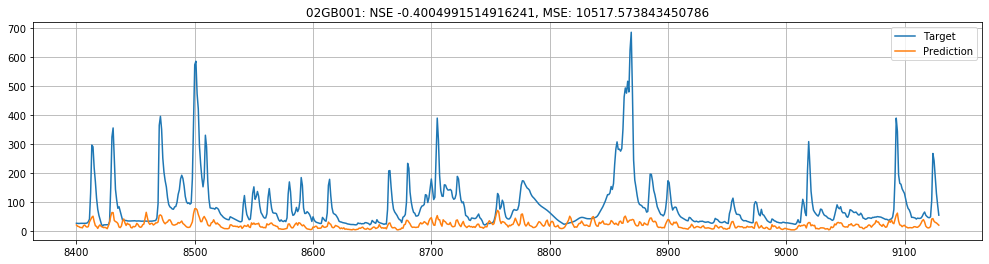

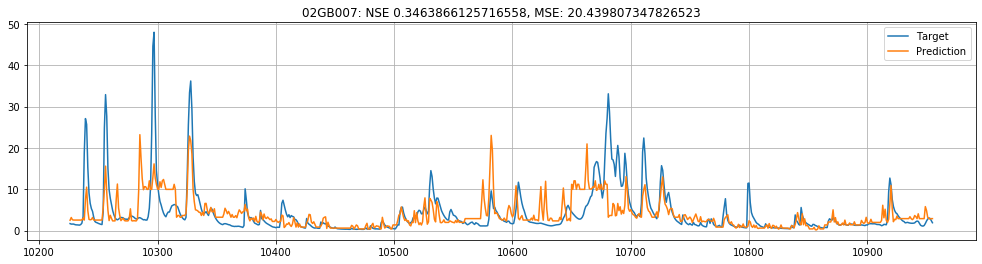

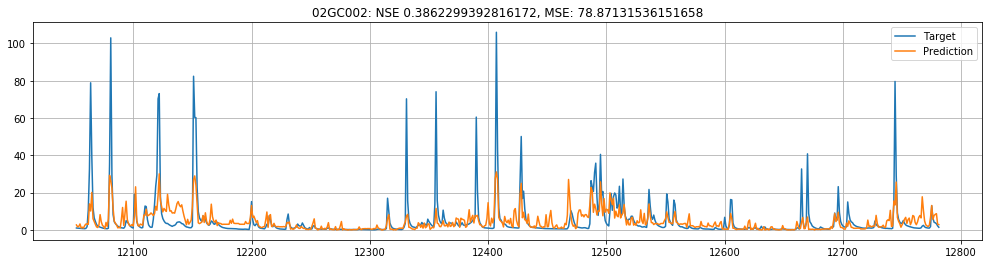

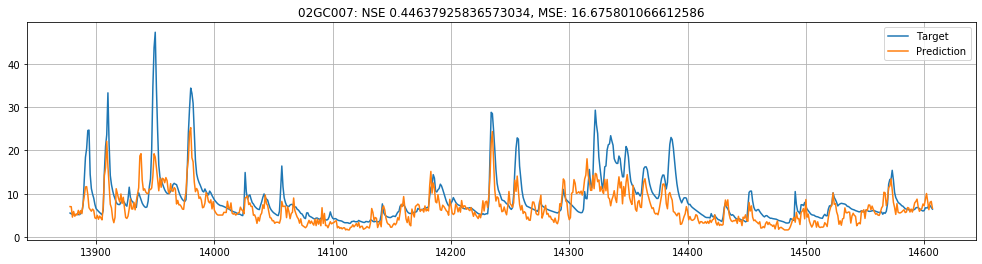

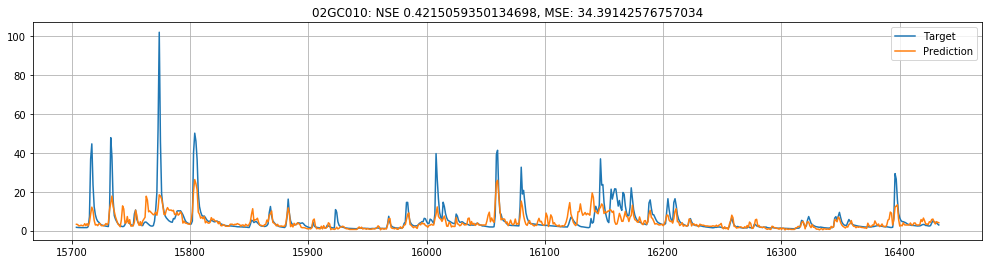

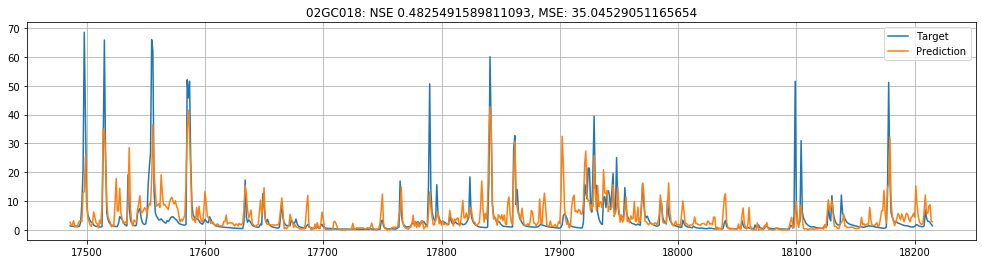

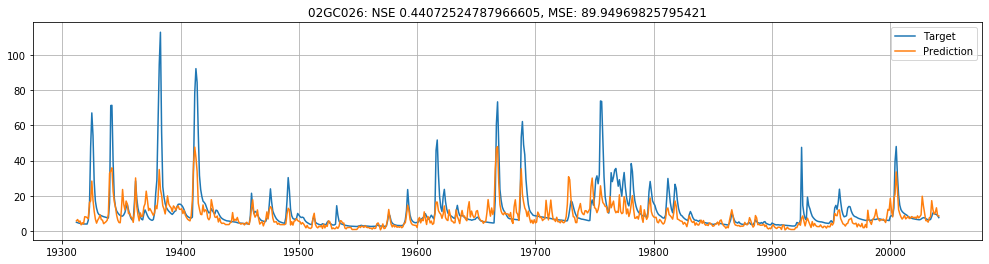

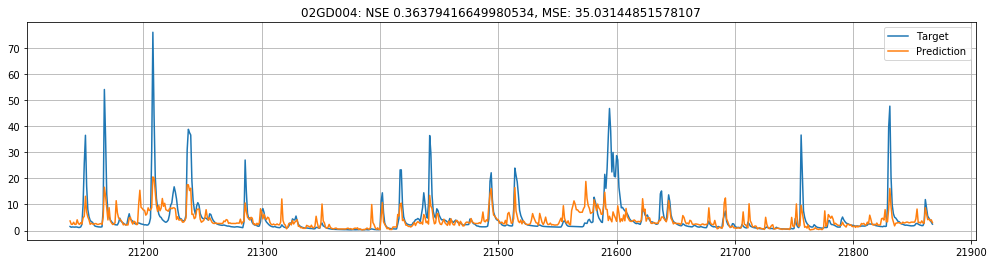

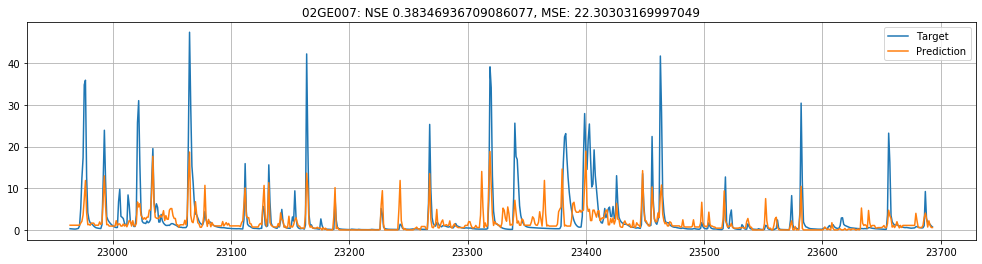

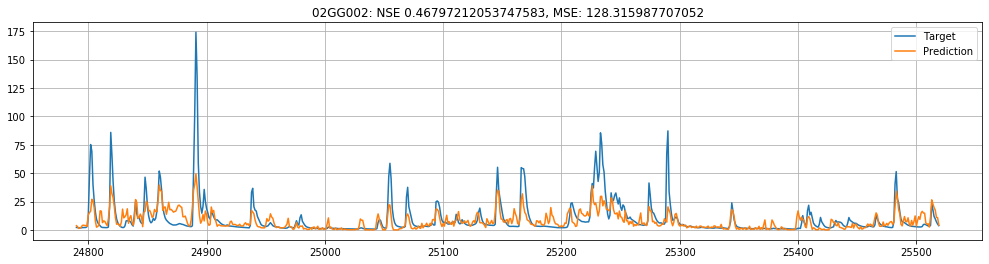

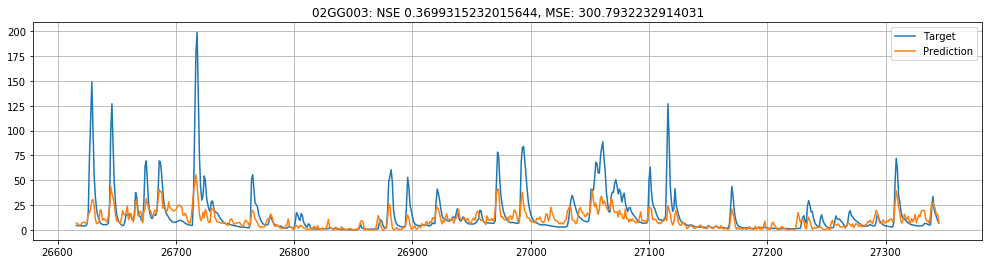

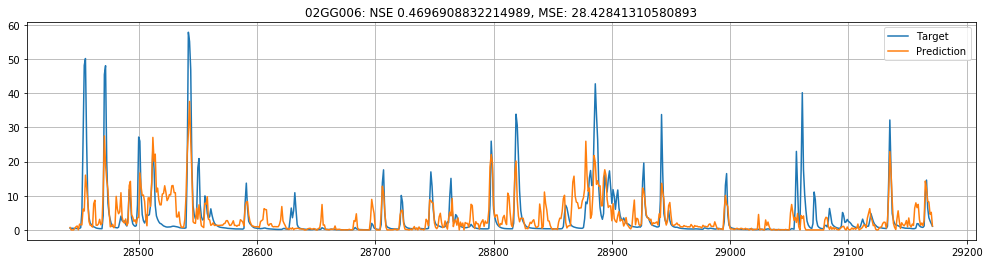

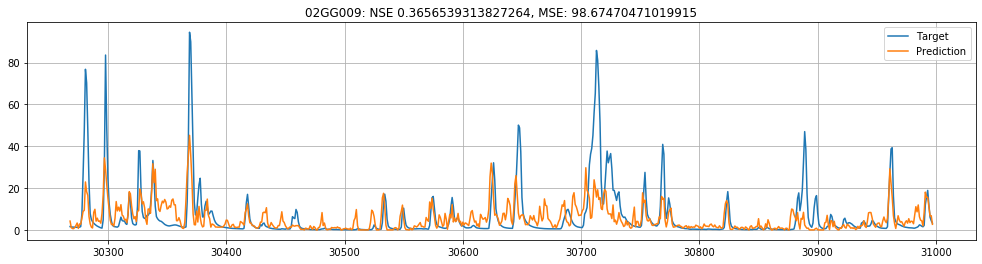

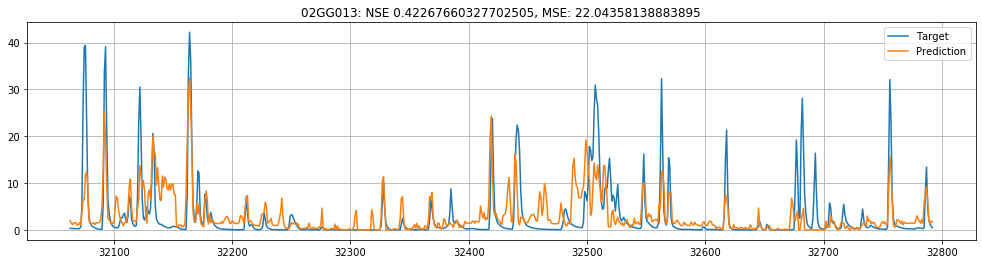

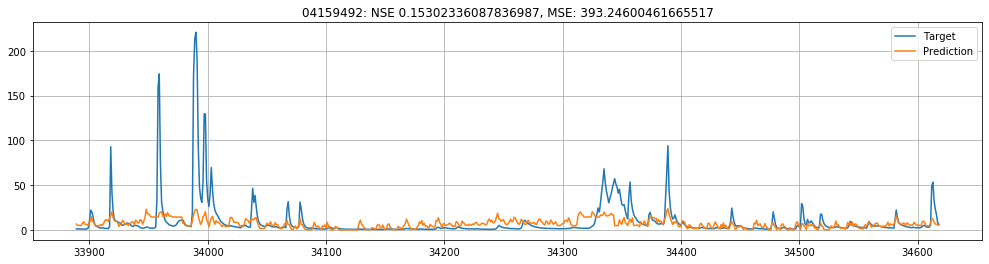

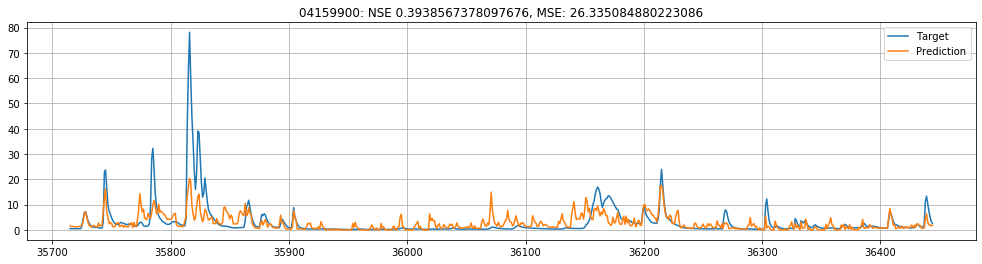

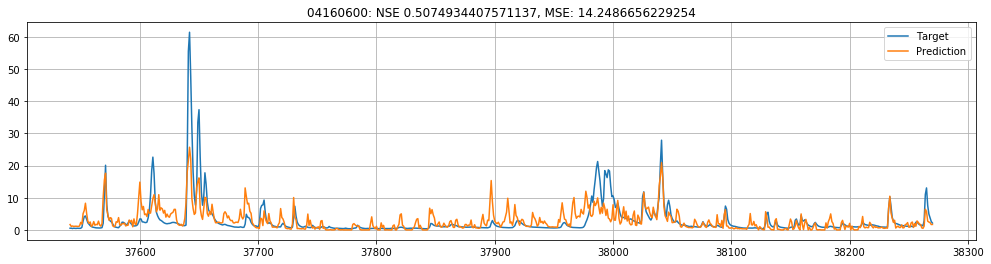

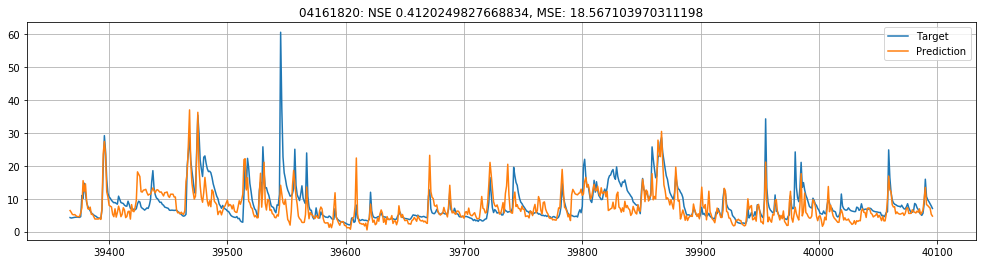

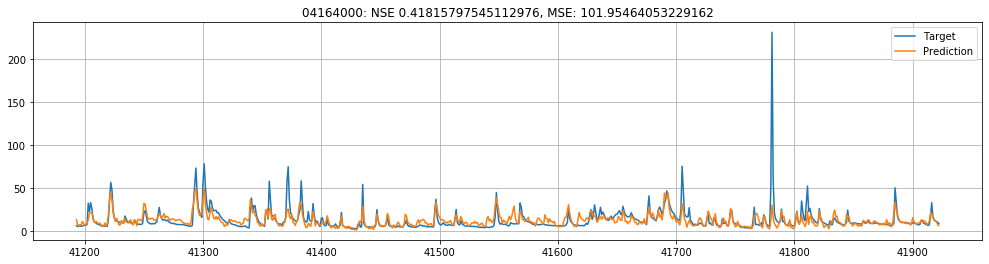

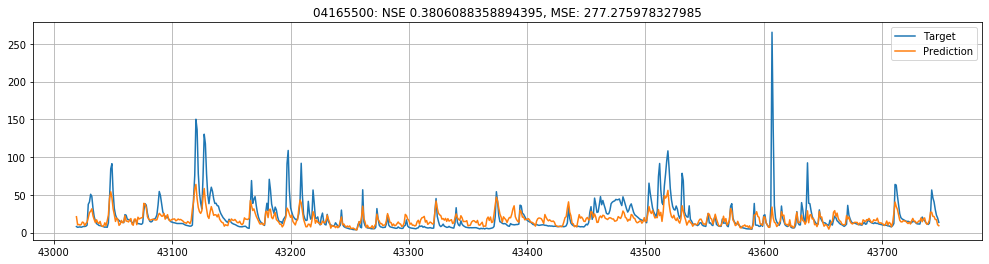

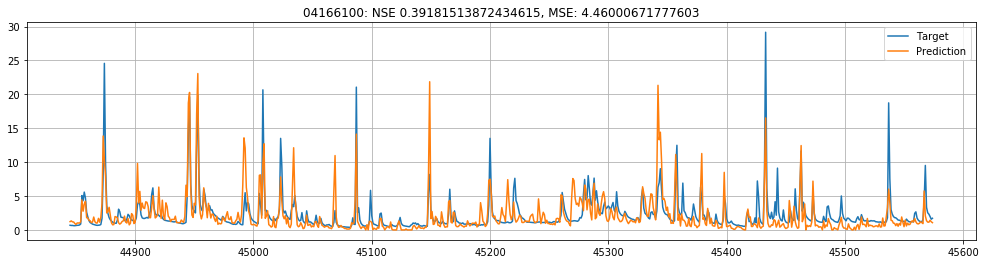

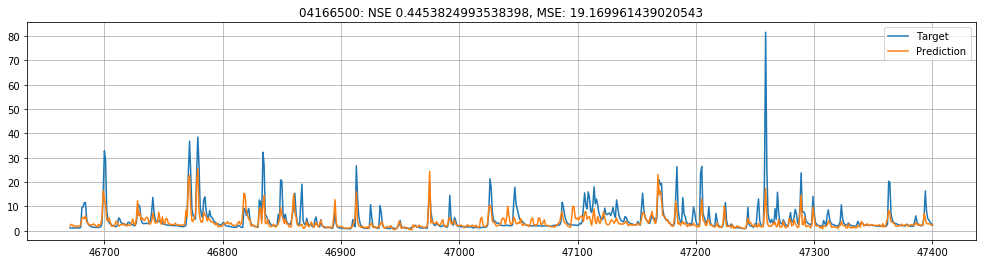

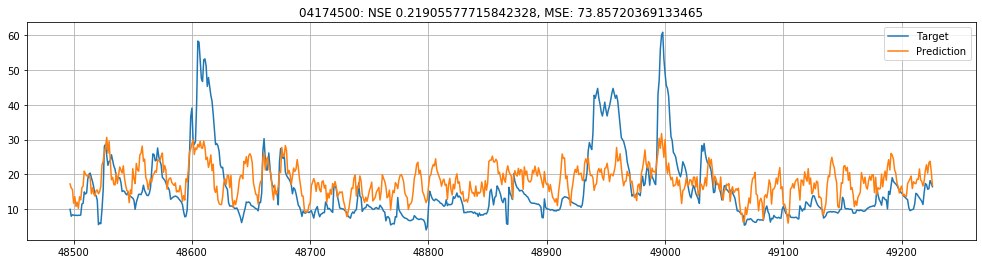

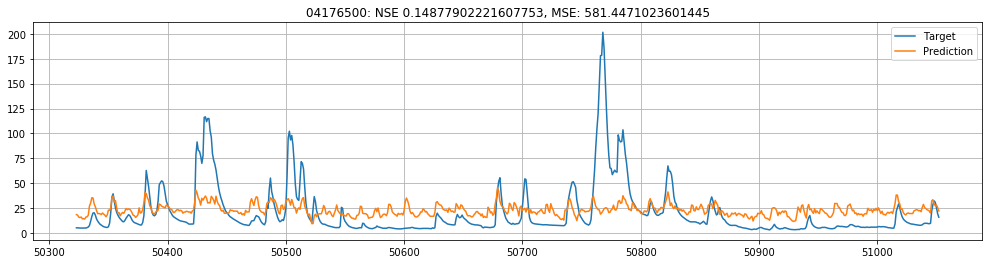

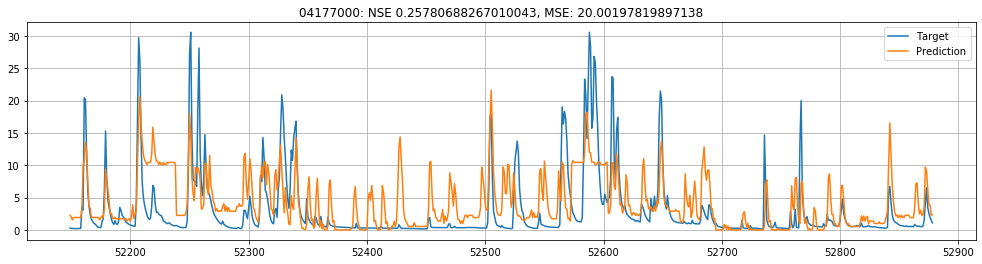

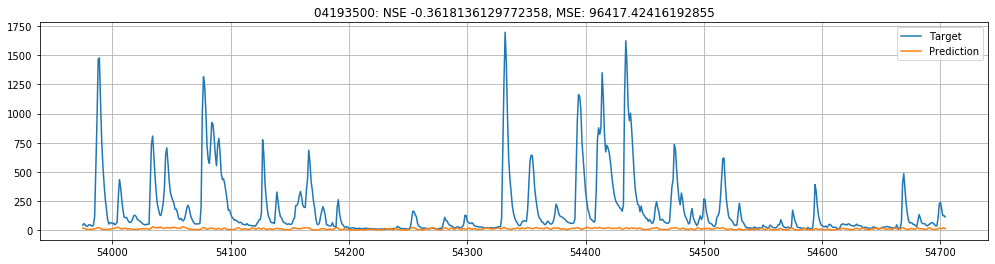

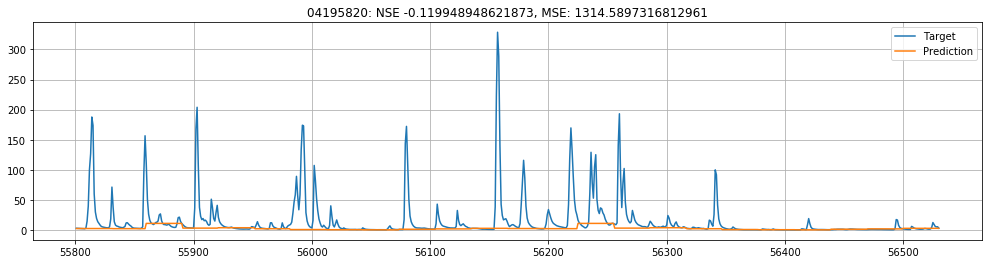

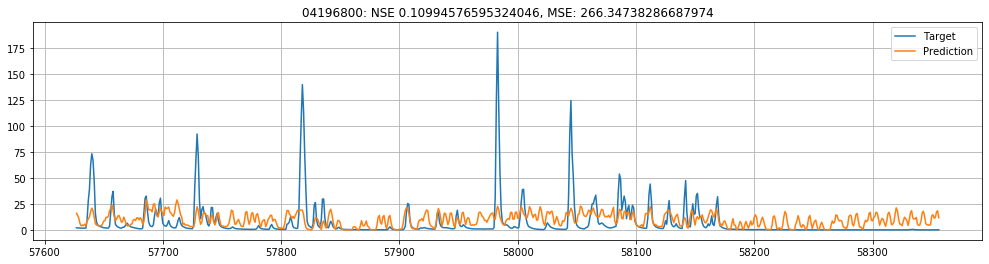

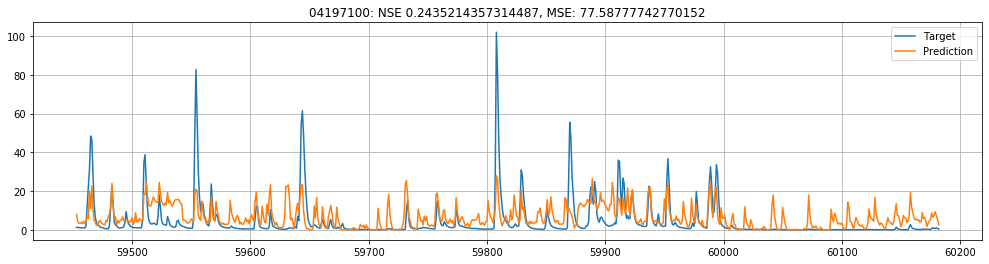

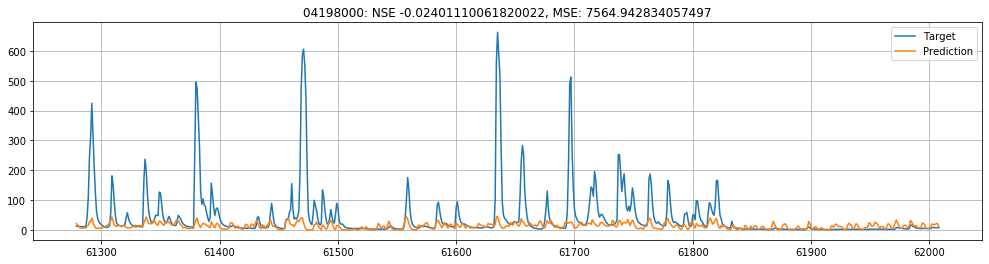

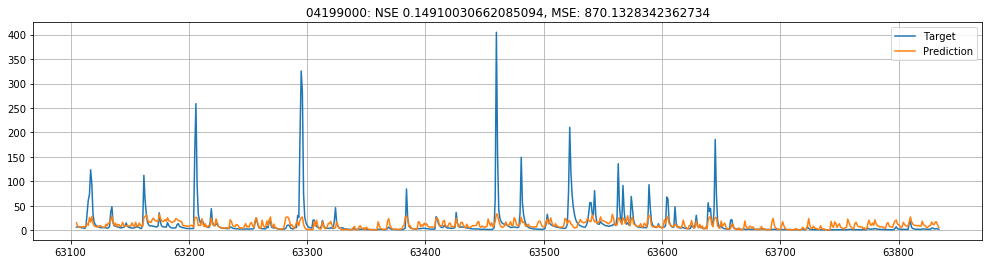

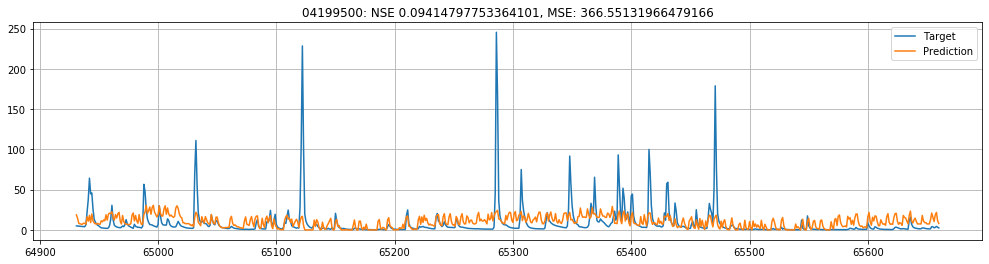

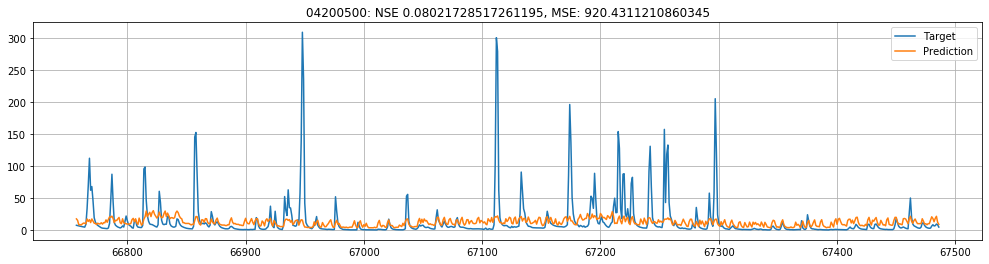

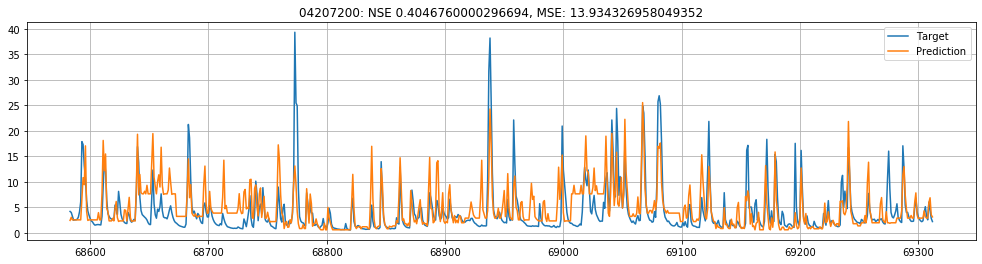

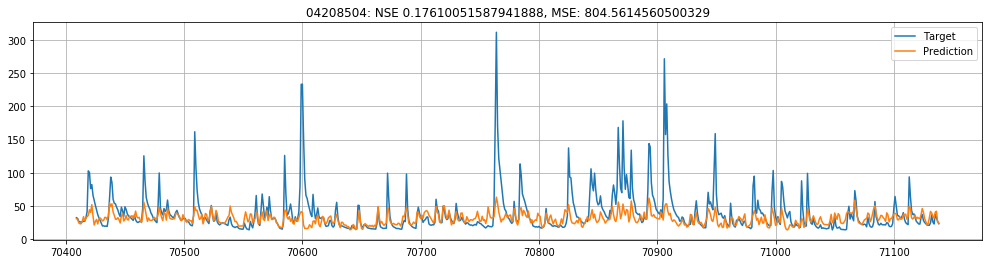

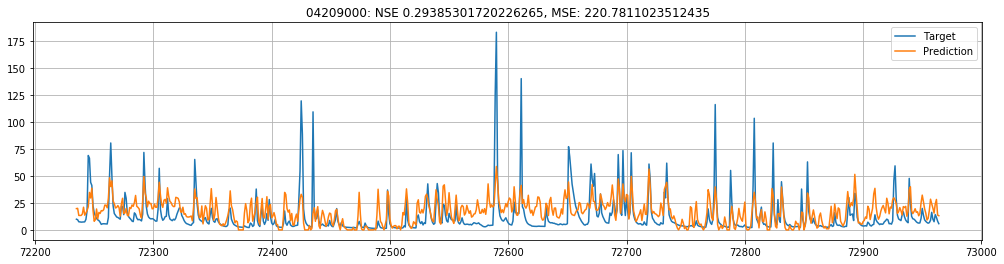

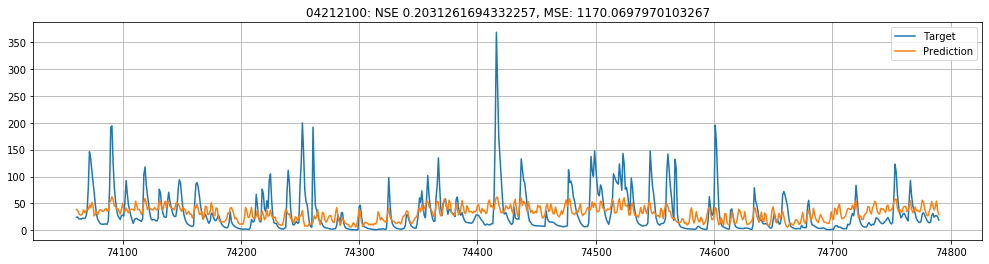

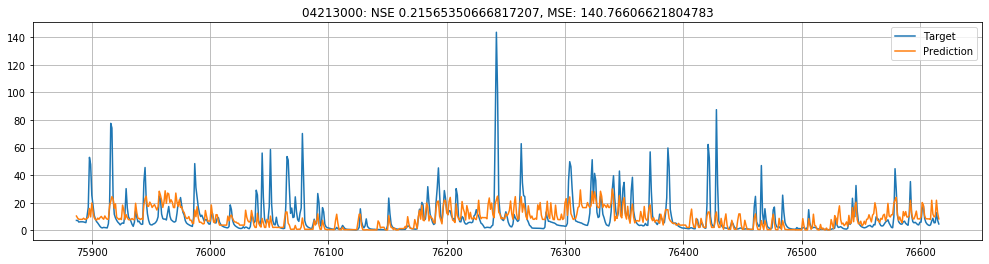

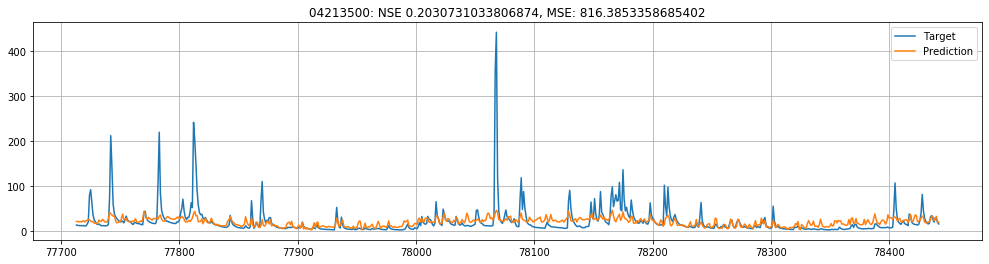

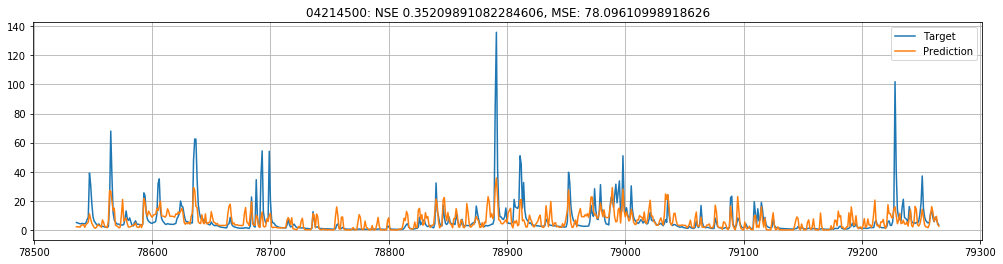

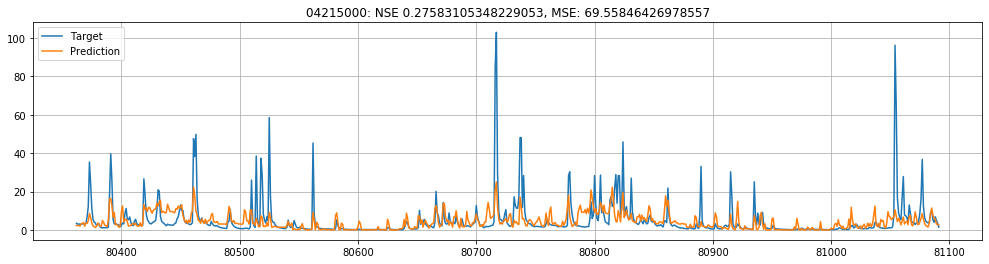

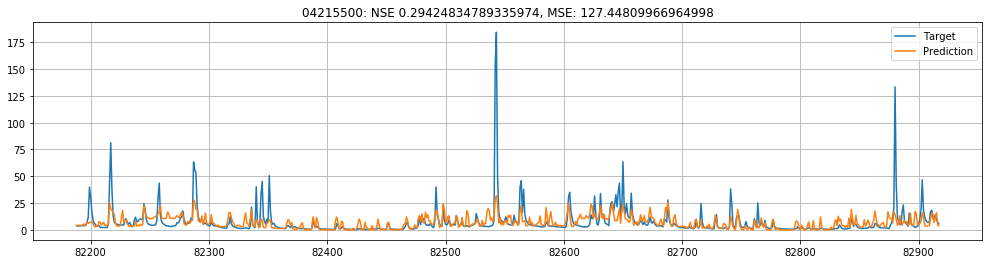

In [6]:
nse_list = []
mse_list = []
grouped_predict = predict.groupby('station')
for station in grouped_predict.groups.keys():
    station_predict = grouped_predict.get_group(station)
    nse, mse = evaluate.evaluate_daily(station, station_predict[['runoff']], station_predict['actual'], plot=True)
    nse_list.append(nse)
    mse_list.append(mse)
    
    print(station, '\tNSE:', nse, '\tMSE:', mse, '(clipped to 0)')

print('Median NSE (clipped to 0)', np.median(nse_list), '/ Min', np.min(nse_list), '/ Max', np.max(nse_list))
print('Median MSE (clipped to 0)', np.median(mse_list), '/ Min', np.min(mse_list), '/ Max', np.max(mse_list))

In [7]:
load_data.pickle_results('XGBoost_VIC_aggregateForcings_oneModel-NSELoss', predict[['date', 'station', 'runoff', 'actual']].rename({'runoff': 'prediction'}, axis=1).reset_index(drop=True), time_stamp)

'XGBoost_VIC_aggregateForcings_oneModel-NSELoss_20190908-103648.pkl'

In [8]:
load_data.pickle_model('XGBoost_VIC_aggregateForcings_oneModel-NSELoss', m, 'all', time_stamp, model_type='sklearn')

Saved model as /home/mgauch/runoff-nn/src/../pickle/models/XGBoost_VIC_aggregateForcings_oneModel-NSELoss_all_20190908-103648.pkl


In [9]:
datetime.now().strftime('%Y%m%d-%H%M%S')

'20190908-223935'